In [6]:
# Define the environment
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import TRPO

# Define the market environment
class MarketEnvironment(gym.Env):
    def __init__(self):
        super(MarketEnvironment, self).__init__()

        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions, Box(2,) for two sellers
        self.action_space = spaces.MultiDiscrete([101, 101])

        # Prices could range from 0 to 100, there are four buyers
        self.observation_space = spaces.Box(low=0, high=100, shape=(6,))
        self.prices_history = []


        # Initialize state
        self.reset()

    def step(self, action):
        # Execute one time step within the environment
        assert self.action_space.contains(action)

        # Simple model: buyers buy from the cheapest seller
        sorted_sellers = np.argsort(action)
        self.state[0] = action[sorted_sellers[0]]
        self.state[1] = action[sorted_sellers[1]]

        # Distribute the buyers
        for i in range(2, 6):
            if self.state[i] >= self.state[0]:
                self.state[0] += self.state[i]
                self.state[i] = 0
            elif self.state[i] >= self.state[1]:
                self.state[1] += self.state[i]
                self.state[i] = 0

        # Set reward as the profit of the sellers
        reward = self.state[0] + self.state[1]

        # Set done flag if all buyers have bought the products
        done = np.sum(self.state[2:]) == 0

        # Save the prices to history
        self.prices_history.append(action)

        return self.state, reward, done, {}


    def reset(self):
        # Reset the state of the environment to an initial state
        self.state = np.zeros(6)
        # Initialize buyers' willingness to pay
        self.state[2:6] = np.random.uniform(low=0, high=100, size=4)
        return self.state

# Initialize environment
env = MarketEnvironment()

# Initialize reinforcement learning agents
model1 = PPO("MlpPolicy", env, verbose=1)
model2 = TRPO("MlpPolicy", env, verbose=1)
# Train agents
model1.learn(total_timesteps=10000)
model2.learn(total_timesteps=10000)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.9      |
|    ep_rew_mean     | 1.06e+03 |
| time/              |          |
|    fps             | 895      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.7         |
|    ep_rew_mean          | 1.48e+03     |
| time/                   |              |
|    fps                  | 751          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0016172617

In [7]:
def evaluate_model(model, env, num_episodes=1):
    episode_rewards = []
    episode_actions = []
    for i in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        actions = []
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            actions.append(action)
        episode_rewards.append(episode_reward)
        episode_actions.append(actions)
    return np.mean(episode_rewards), episode_actions

# Evaluate the first agent
mean_reward1, actions1 = evaluate_model(model1, env)
print(f"Mean reward for the first agent: {mean_reward1}")

# Evaluate the second agent
mean_reward2, actions2 = evaluate_model(model2, env)
print(f"Mean reward for the second agent: {mean_reward2}")



Mean reward for the first agent: 6779.375948584347
Mean reward for the second agent: 618.5249599327617


[[array([54, 71]),
  array([91, 93]),
  array([49, 35]),
  array([36, 94]),
  array([31, 74]),
  array([45, 11]),
  array([78, 99]),
  array([100,  20]),
  array([43, 67]),
  array([ 3, 55]),
  array([ 5, 55]),
  array([96, 40]),
  array([22, 32]),
  array([13, 65]),
  array([61, 28]),
  array([23, 84]),
  array([51, 88]),
  array([50,  3]),
  array([15, 48]),
  array([90, 23]),
  array([47, 75]),
  array([20, 21]),
  array([55, 25]),
  array([98, 26]),
  array([25, 35]),
  array([61, 50]),
  array([92, 65]),
  array([70, 80]),
  array([53, 62]),
  array([100,  99]),
  array([99, 59]),
  array([85, 31]),
  array([11, 48]),
  array([37, 91]),
  array([43, 12]),
  array([81,  7]),
  array([43, 19]),
  array([15, 41]),
  array([86, 30]),
  array([99, 49]),
  array([58, 87]),
  array([46, 61]),
  array([78, 32]),
  array([79, 36]),
  array([36, 67]),
  array([10,  7]),
  array([68, 44]),
  array([71, 73]),
  array([ 8, 80]),
  array([85, 48]),
  array([72, 12]),
  array([100,  91]),
  arra

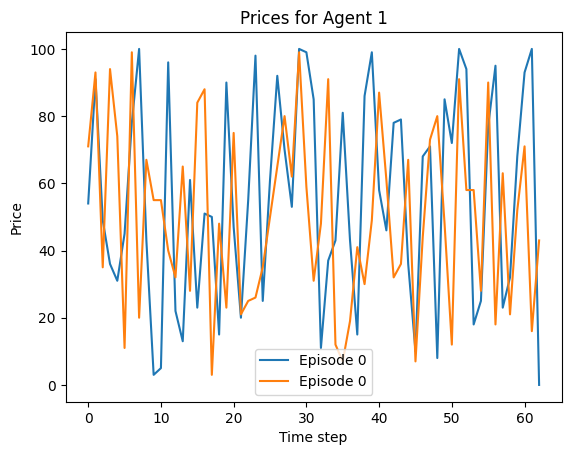

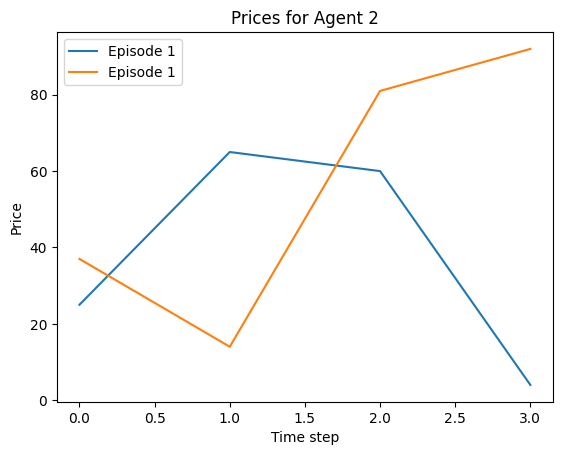

In [10]:
import matplotlib.pyplot as plt

# Plot prices for the first agent
for i, actions in enumerate(actions1):
    plt.plot(actions, label=f'Episode {i+1}')
plt.title('Prices for Agent 1')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot prices for the second agent
for i, actions in enumerate(actions2):
    plt.plot(actions, label=f'Episode {i+1}')
plt.title('Prices for Agent 2')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [1]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import TRPO

# Define the market environment
class MarketEnvironment(gym.Env):
    def __init__(self):
        super(MarketEnvironment, self).__init__()

        # Define action and observation space
        self.action_space = spaces.MultiDiscrete([101, 101])  # Two sellers, prices ranging from 0 to 100

        # State: [seller1_price, seller2_price, buyer1_wtp, buyer2_wtp, buyer3_wtp, buyer4_wtp]
        self.observation_space = spaces.Box(low=0, high=100, shape=(6,))

        # Initialize state
        self.reset()

    def step(self, action):
        assert self.action_space.contains(action)

        # Update sellers' prices
        self.state[0] = action[0]
        self.state[1] = action[1]

        # Calculate buyers' willingness to pay based on the seller's price
        for i in range(2, 6):
            self.state[i] = max(0, 100 - 0.5 * min(self.state[0], self.state[1]))  # example linear function, adjust as needed

        # Distribute the buyers
        for i in range(2, 6):
            if self.state[i] >= self.state[0]:
                self.state[0] += self.state[i]
                self.state[i] = 0
            elif self.state[i] >= self.state[1]:
                self.state[1] += self.state[i]
                self.state[i] = 0

        # Set reward as the profit of the sellers
        reward = self.state[0] + self.state[1]

        # Set done flag if all buyers have bought the products
        done = np.sum(self.state[2:]) == 0

        return self.state, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.state = np.zeros(6)
        return self.state

# Initialize environment
env = MarketEnvironment()

# Initialize reinforcement learning agents
model1 = PPO("MlpPolicy", env, verbose=1)
model2 = TRPO("MlpPolicy", env, verbose=1)

# Train agents
model1.learn(total_timesteps=10000)
model2.learn(total_timesteps=10000)



2023-05-15 21:10:47.583401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 21:10:48.101992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-15 21:10:48.102031: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-15 21:10:48.102035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 761  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 698           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 9.0896996e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -9.23         |
|    explained_variance   | 3.98e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 

In [2]:
def evaluate_model(model, env, num_episodes=10):
    episode_rewards = []
    episode_actions = []
    for i in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        actions = []
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            actions.append(action)
        episode_rewards.append(episode_reward)
        episode_actions.append(actions)
    return np.mean(episode_rewards), episode_actions

# Evaluate the first agent
mean_reward1, actions1 = evaluate_model(model1, env)
print(f"Mean reward for the first agent: {mean_reward1}")

# Evaluate the second agent
mean_reward2, actions2 = evaluate_model(model2, env)
print(f"Mean reward for the second agent: {mean_reward2}")

Mean reward for the first agent: 2417642.75
Mean reward for the second agent: 652255.05


[[array([50, 81]),
  array([22, 80]),
  array([76, 92]),
  array([56, 57]),
  array([17, 57]),
  array([86, 68]),
  array([18, 56]),
  array([77, 35]),
  array([80, 16]),
  array([19, 54]),
  array([15, 33]),
  array([13, 14]),
  array([57,  3]),
  array([87, 23]),
  array([82, 38]),
  array([64, 50]),
  array([75, 98]),
  array([60, 76]),
  array([50,  9]),
  array([81, 33]),
  array([14,  2]),
  array([16, 11]),
  array([83, 64]),
  array([59, 81]),
  array([90, 26]),
  array([11, 57]),
  array([26, 66]),
  array([34, 46]),
  array([46, 83]),
  array([50, 37]),
  array([99, 96]),
  array([ 1, 25]),
  array([43, 26]),
  array([50,  5]),
  array([81, 97]),
  array([60,  5]),
  array([35, 70]),
  array([60, 73]),
  array([82,  5]),
  array([19, 63]),
  array([23, 52]),
  array([7, 7]),
  array([14, 97]),
  array([70, 65]),
  array([99, 88]),
  array([54, 96]),
  array([53,  6]),
  array([55, 14]),
  array([96, 44]),
  array([11, 65]),
  array([40, 78]),
  array([43, 34]),
  array([40, 7

In [ ]:
# Evaluate the agents
num_episodes = 100
actions1 = []
actions2 = []

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    while not done:
        action1 = model1.predict(obs)[0]

        actions1.append(action1)

        obs, reward, done, info = env.step(action1)

# Print actions taken by the agents
print("Actions taken by agent 1:", actions1)


In [ ]:
import matplotlib.pyplot as plt

# Convert actions to numpy arrays for easier manipulation
actions1 = np.array(actions1)
actions2 = np.array(actions2)

# Plot prices set by agent 1
plt.plot(actions1, label='Agent 1')

# Plot prices set by agent 2
plt.plot(actions2, label='Agent 2')

plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()
